# Using MCMC for regression of !Kungs' height on their weight

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm
import arviz as az

In [2]:
ALPHA = 0.11

Data

In [3]:
dat = pd.read_csv('Data/Howell1.csv', sep=';').sort_values('weight').reset_index(drop=True)
weight_s = (dat['weight']-dat['weight'].mean())/dat['weight'].std()

---

Fit the model and sample from the prior predictive.

In [4]:
with pm.Model() as ModelHeightWeight:
    alpha    = pm.Normal('alpha', mu=170, sigma=3)
    beta     = pm.Gamma('beta', alpha=4, beta=3)
    sigma    = pm.Uniform('sigma', lower=0, upper=20)
    mu       = pm.Deterministic('mu', alpha + beta * weight_s)
    height   = pm.Normal('height', mu=mu, sigma=sigma, observed=dat['height'])

    TraceModelHeightWeight = pm.sample_prior_predictive()   

Sampling: [alpha, beta, height, sigma]


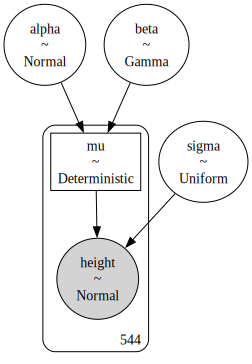

In [5]:
pm.model_to_graphviz(ModelHeightWeight)

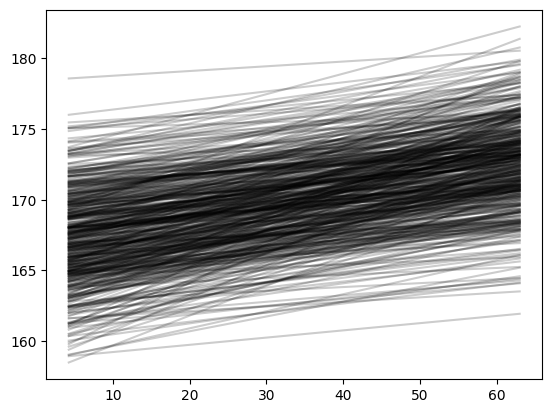

In [6]:
x_min, x_max = dat['weight'].min(), dat['weight'].max()
x = np.linspace((x_min-dat['weight'].mean())/dat['weight'].std(), (x_max-dat['weight'].mean())/dat['weight'].std())

PriorAlpha = TraceModelHeightWeight.prior.alpha.values[0]
PriorBeta = TraceModelHeightWeight.prior.beta.values[0]

for a, b in zip(PriorAlpha, PriorBeta):
    y = a + b*x
    plt.plot(x * dat['weight'].std() + dat['weight'].mean(), y, c='k', alpha=0.2)

Sample from the posterior

In [7]:
with ModelHeightWeight:
    TraceModelHeightWeight.extend(pm.sample())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


array([[<Axes: >, None],
       [<Axes: xlabel='alpha', ylabel='beta'>, <Axes: >]], dtype=object)

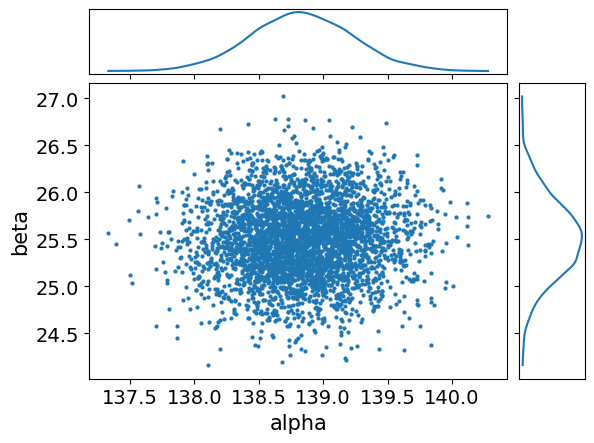

In [8]:
az.plot_pair(TraceModelHeightWeight, var_names=['alpha', 'beta'], marginals=True)

Sample from the predictive posterior

In [9]:
with ModelHeightWeight:
    TraceModelHeightWeight.extend(pm.sample_posterior_predictive(TraceModelHeightWeight))

Sampling: [height]


Plot the posterior predictive

<Axes: xlabel='height / height'>

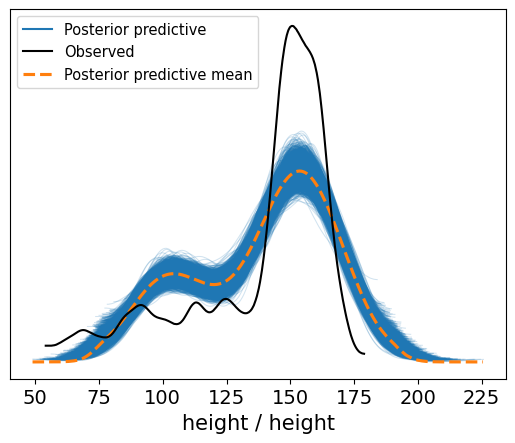

In [10]:
az.plot_ppc(TraceModelHeightWeight)

Plot the regression function with confidence and prediction intervals

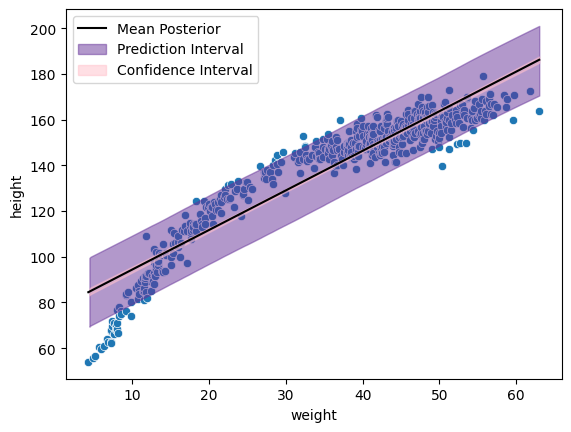

In [11]:
sns.scatterplot(x=dat['weight'], y=dat['height'])

plt.plot(
    dat['weight']
    , TraceModelHeightWeight.posterior.mu.mean(('chain', 'draw'))
    , label="Mean Posterior"
    , color='k'
)

az.plot_hdi(
    dat['weight']
    , TraceModelHeightWeight.posterior_predictive.height
    , hdi_prob=1-ALPHA
    , color='rebeccapurple'
    , fill_kwargs={'alpha': 0.5, 'label':"Prediction Interval"}
)

az.plot_hdi(
    dat['weight']
    , TraceModelHeightWeight.posterior.mu
    , hdi_prob=1-ALPHA
    , color='pink'
    , fill_kwargs={'alpha': 0.5, 'label':"Confidence Interval"}
)

plt.legend()

---

We fit now a quadratic model

In [12]:
with pm.Model() as ModelHeightWeight2:
    alpha    = pm.Normal('alpha', mu=167, sigma=3)
    beta1    = pm.Gamma('beta1', alpha=4, beta=3)
    beta2    = pm.Normal('beta2', mu=0, sigma=1)
    sigma    = pm.Uniform('sigma', lower=0, upper=20)
    mu       = pm.Deterministic('mu', alpha + beta1 * weight_s + beta2 * weight_s**2)
    height   = pm.Normal('height', mu=mu, sigma=sigma, observed=dat['height'])

    TraceModelHeightWeight2 = pm.sample_prior_predictive()   

Sampling: [alpha, beta1, beta2, height, sigma]


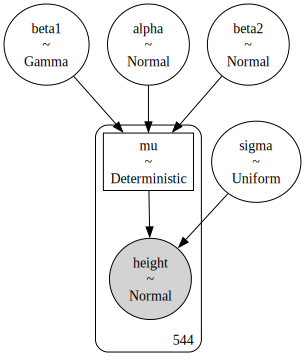

In [13]:
pm.model_to_graphviz(ModelHeightWeight2)

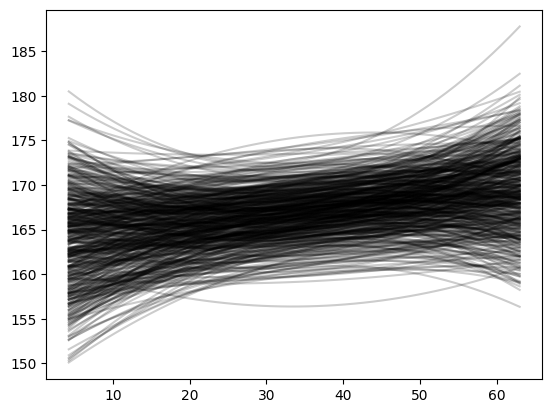

In [14]:
x_min, x_max = dat['weight'].min(), dat['weight'].max()
x = np.linspace((x_min-dat['weight'].mean())/dat['weight'].std(), (x_max-dat['weight'].mean())/dat['weight'].std())

PriorAlpha = TraceModelHeightWeight2.prior.alpha.values[0]
PriorBeta1 = TraceModelHeightWeight2.prior.beta1.values[0]
PriorBeta2 = TraceModelHeightWeight2.prior.beta2.values[0]

for a, b, c in zip(PriorAlpha, PriorBeta1, PriorBeta2):
    y = a + b*x + c*x**2
    plt.plot(x * dat['weight'].std() + dat['weight'].mean(), y, c='k', alpha=0.2)

In [15]:
with ModelHeightWeight2:
    TraceModelHeightWeight2.extend(pm.sample())
    TraceModelHeightWeight2.extend(pm.sample_posterior_predictive(TraceModelHeightWeight2))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Sampling: [height]


Plot the posterior predictive

<Axes: xlabel='height / height'>

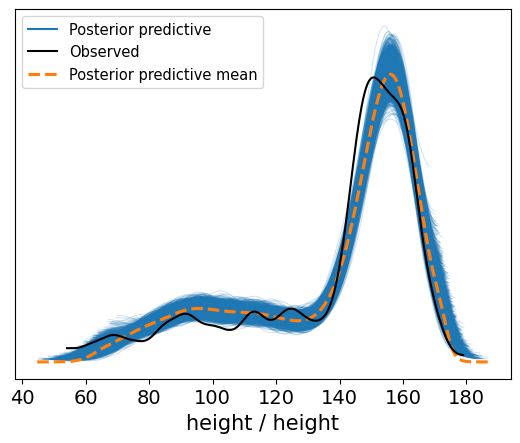

In [16]:
az.plot_ppc(TraceModelHeightWeight2)

Plot the regression function with confidence and prediction intervals

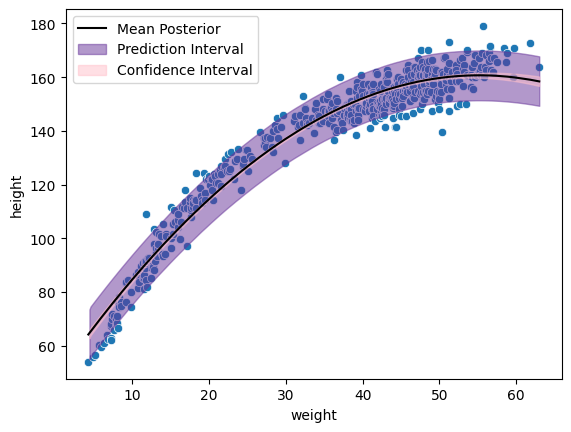

In [17]:
sns.scatterplot(x=dat['weight'], y=dat['height'])

plt.plot(
    dat['weight']
    , TraceModelHeightWeight2.posterior.mu.mean(('chain', 'draw'))
    , label="Mean Posterior"
    , color='k'
)

az.plot_hdi(
    dat['weight']
    , TraceModelHeightWeight2.posterior_predictive.height
    , hdi_prob=1-ALPHA
    , color='rebeccapurple'
    , fill_kwargs={'alpha': 0.5, 'label':"Prediction Interval"}
)

az.plot_hdi(
    dat['weight']
    , TraceModelHeightWeight2.posterior.mu
    , hdi_prob=1-ALPHA
    , color='pink'
    , fill_kwargs={'alpha': 0.5, 'label':"Confidence Interval"}
)

plt.legend()